A.S. Lundervold og A. Lundervold, versjon 31.12.2018

# Introduksjon

Denne notebooken er ment som en relativt enkel illustrasjon av analyse av sensordata med maskinlæring. Se slides fra introduksjonen for motivasjon. 

# Setup

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from pathlib import Path
import subprocess

# Data

Vi bruker et sensor-datasett fra UCI Machine Learning, tilgjenglig via Kaggle: https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones. Fra 30 personer ble det samlet målinger fra en smart-telefon mens de utførte dagligdagse oppgaver. Vår oppgave er å predikere hvilken oppgave som ble utført direkte fra sensor-målingene. 

Video som beskriver innsamlingen av data: https://www.youtube.com/watch?v=XOEN9W05_4A

In [2]:
import IPython
IPython.display.IFrame(width="560", height="315", src="https://www.youtube.com/embed/XOEN9W05_4A")

Her er en beskrivelse av datasettet, sakset fra Kaggle:

The Human Activity Recognition database was built from the recordings of 30 study participants performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors. The objective is to classify activities into one of the six activities performed.

> **Description of experiment**<br>
The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where **70% of the volunteers was selected for generating the training data and 30% the test data**.

> The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain.

> **Attribute information**<br>
> For each record in the dataset the following is provided:

> * Triaxial acceleration from the accelerometer (total acceleration) and the estimated body acceleration.
* Triaxial Angular velocity from the gyroscope.
* A 561-feature vector with time and frequency domain variables.
* Its activity label.
* An identifier of the subject who carried out the experiment.

## Last inn og utforsk data

Vi har allerede hentet data fra Kaggle. Plassert i katalogen `../data`

In [3]:
DATA = Path('../data/sensor')

In [5]:
train = pd.read_csv(DATA/'train.csv')
test = pd.read_csv(DATA/'test.csv')

Vi har fått to dataframes bestående av en lang rekke sensormålinger, markert med tilhørende aktiviteter:

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 31.6+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 12.7+ MB


Vi ser at det er 7352 treningsdata og 2947 testdata.

Hvordan ser data ut? 

In [8]:
# For å vise alle søylene i data frames:
pd.set_option('display.max_columns', 600)

In [9]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,"tGravityAcc-arCoeff()-X,1","tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,3","tGravityAcc-arCoeff()-X,4","tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y","tGravityAcc-correlation()-X,Z","tGravityAcc-correlation()-Y,Z",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,tBodyAccJerk-mean()-Z,tBodyAccJerk-std()-X,tBodyAccJerk-std()-Y,tBodyAccJerk-std()-Z,tBodyAccJerk-mad()-X,tBodyAccJerk-mad()-Y,tBodyAccJerk-mad()-Z,tBodyAccJerk-max()-X,tBodyAccJerk-max()-Y,tBodyAccJerk-max()-Z,tBodyAccJerk-min()-X,tBodyAccJerk-min()-Y,tBodyAccJerk-min()-Z,tBodyAccJerk-sma(),tBodyAccJerk-energy()-X,tBodyAccJerk-energy()-Y,tBodyAccJerk-energy()-Z,tBodyAccJerk-iqr()-X,tBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Z,tBodyAccJerk-entropy()-X,tBodyAccJerk-entropy()-Y,tBodyAccJerk-entropy()-Z,"tBodyAccJerk-arCoeff()-X,1","tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3","tBodyAccJerk-arCoeff()-X,4","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,2","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,4","tBodyAccJerk-arCoeff()-Z,1","tBodyAccJerk-arCoeff()-Z,2","tBodyAccJerk-arCoeff()-Z,3","tBodyAccJerk-arCoeff()-Z,4","tBodyAccJerk-correlation()-X,Y","tBodyAccJerk-correlation()-X,Z","tBodyAccJerk-correlation()-Y,Z",tBodyGyro-mean()-X,tBodyGyro-mean()-Y,tBodyGyro-mean()-Z,tBodyGyro-std()-X,tBodyGyro-std()-Y,tBodyGyro-std()-Z,tBodyGyro-mad()-X,tBodyGyro-mad()-Y,tBodyGyro-mad()-Z,tBodyGyro-max()-X,tBodyGyro-max()-Y,tBodyGyro-max()-Z,tBodyGyro-min()-X,tBodyGyro-min()-Y,tBodyGyro-min()-Z,tBodyGyro-sma(),tBodyGyro-energy()-X,tBodyGyro-energy()-Y,tBodyGyro-energy()-Z,tBodyGyro-iqr()-X,tBodyGyro-iqr()-Y,tBodyGyro-iqr()-Z,tBodyGyro-entropy()-X,tBodyGyro-entropy()-Y,tBodyGyro-entropy()-Z,"tBodyGyro-arCoeff()-X,1","tBodyGyro-arCoeff()-X,2","tBodyGyro-arCoeff()-X,3","tBodyGyro-arCoeff()-X,4","tBodyGyro-arCoeff()-Y,1","tBodyGyro-arCoeff()-Y,2","tBodyGyro-arCoeff()-Y,3","tBodyGyro-arCoeff()-Y,4","tBodyGyro-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,2","tBodyGyro-arCoeff()-Z,3","tBodyGyro-arCoeff()-Z,4","tBodyGyro-correlation()-X,Y","tBodyGyro-correlation()-X,Z","tBodyGyro-correlation()-Y,Z",tBodyGyroJerk-mean()-X,tBodyGyroJerk-mean()-Y,tBodyGyroJerk-mean()-Z,tBodyGyroJerk-std()-X,tBodyGyroJerk-std()-Y,tBodyGyroJerk-std()-Z,tBodyGyroJerk-mad()-X,tBodyGyroJerk-mad()-Y,tBodyGyroJerk-mad()-Z,tBodyGyroJerk-max()-X,tBodyGyroJerk-max()-Y,tBodyGyroJerk-max()-Z,tBodyGyroJerk-min()-X,tBodyGyroJerk-min()-Y,tBodyGyroJerk-min()-Z,tBodyGyroJ

In [10]:
test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,"tGravityAcc-arCoeff()-X,1","tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,3","tGravityAcc-arCoeff()-X,4","tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y","tGravityAcc-correlation()-X,Z","tGravityAcc-correlation()-Y,Z",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,tBodyAccJerk-mean()-Z,tBodyAccJerk-std()-X,tBodyAccJerk-std()-Y,tBodyAccJerk-std()-Z,tBodyAccJerk-mad()-X,tBodyAccJerk-mad()-Y,tBodyAccJerk-mad()-Z,tBodyAccJerk-max()-X,tBodyAccJerk-max()-Y,tBodyAccJerk-max()-Z,tBodyAccJerk-min()-X,tBodyAccJerk-min()-Y,tBodyAccJerk-min()-Z,tBodyAccJerk-sma(),tBodyAccJerk-energy()-X,tBodyAccJerk-energy()-Y,tBodyAccJerk-energy()-Z,tBodyAccJerk-iqr()-X,tBodyAccJerk-iqr()-Y,tBodyAccJerk-iqr()-Z,tBodyAccJerk-entropy()-X,tBodyAccJerk-entropy()-Y,tBodyAccJerk-entropy()-Z,"tBodyAccJerk-arCoeff()-X,1","tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-X,3","tBodyAccJerk-arCoeff()-X,4","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,2","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Y,4","tBodyAccJerk-arCoeff()-Z,1","tBodyAccJerk-arCoeff()-Z,2","tBodyAccJerk-arCoeff()-Z,3","tBodyAccJerk-arCoeff()-Z,4","tBodyAccJerk-correlation()-X,Y","tBodyAccJerk-correlation()-X,Z","tBodyAccJerk-correlation()-Y,Z",tBodyGyro-mean()-X,tBodyGyro-mean()-Y,tBodyGyro-mean()-Z,tBodyGyro-std()-X,tBodyGyro-std()-Y,tBodyGyro-std()-Z,tBodyGyro-mad()-X,tBodyGyro-mad()-Y,tBodyGyro-mad()-Z,tBodyGyro-max()-X,tBodyGyro-max()-Y,tBodyGyro-max()-Z,tBodyGyro-min()-X,tBodyGyro-min()-Y,tBodyGyro-min()-Z,tBodyGyro-sma(),tBodyGyro-energy()-X,tBodyGyro-energy()-Y,tBodyGyro-energy()-Z,tBodyGyro-iqr()-X,tBodyGyro-iqr()-Y,tBodyGyro-iqr()-Z,tBodyGyro-entropy()-X,tBodyGyro-entropy()-Y,tBodyGyro-entropy()-Z,"tBodyGyro-arCoeff()-X,1","tBodyGyro-arCoeff()-X,2","tBodyGyro-arCoeff()-X,3","tBodyGyro-arCoeff()-X,4","tBodyGyro-arCoeff()-Y,1","tBodyGyro-arCoeff()-Y,2","tBodyGyro-arCoeff()-Y,3","tBodyGyro-arCoeff()-Y,4","tBodyGyro-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,2","tBodyGyro-arCoeff()-Z,3","tBodyGyro-arCoeff()-Z,4","tBodyGyro-correlation()-X,Y","tBodyGyro-correlation()-X,Z","tBodyGyro-correlation()-Y,Z",tBodyGyroJerk-mean()-X,tBodyGyroJerk-mean()-Y,tBodyGyroJerk-mean()-Z,tBodyGyroJerk-std()-X,tBodyGyroJerk-std()-Y,tBodyGyroJerk-std()-Z,tBodyGyroJerk-mad()-X,tBodyGyroJerk-mad()-Y,tBodyGyroJerk-mad()-Z,tBodyGyroJerk-max()-X,tBodyGyroJerk-max()-Y,tBodyGyroJerk-max()-Z,tBodyGyroJerk-min()-X,tBodyGyroJerk-min()-Y,tBodyGyroJerk-min()-Z,tBodyGyroJ

Her er noen labels:

In [11]:
np.random.choice(train['Activity'], size=50)

array(['SITTING', 'LAYING', 'LAYING', 'WALKING', 'SITTING', 'LAYING',
       'LAYING', 'SITTING', 'STANDING', 'LAYING', 'WALKING_DOWNSTAIRS',
       'WALKING', 'SITTING', 'SITTING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS',
       'LAYING', 'WALKING', 'SITTING', 'WALKING_UPSTAIRS',
       'WALKING_UPSTAIRS', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS', 'WALKING_UPSTAIRS',
       'LAYING', 'LAYING', 'LAYING', 'STANDING', 'SITTING', 'STANDING',
       'WALKING', 'LAYING', 'LAYING', 'LAYING', 'WALKING', 'STANDING',
       'LAYING', 'STANDING', 'STANDING', 'WALKING_UPSTAIRS',
       'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS', 'LAYING', 'WALKING',
       'WALKING', 'LAYING'], dtype=object)

De seks ulike aktivitetene vi skal detektere er:

In [12]:
np.unique(train['Activity'])

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

Fordelingen av disse i treningsdata er:

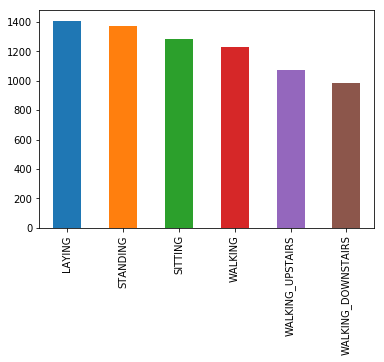

In [13]:
train['Activity'].value_counts().plot(kind='bar')
plt.show()

## Ekstra: korrelasjoner

Det er helt sikkert stor korrelasjon mellom mange av features i dette datasettet (akselerasjon og gyroskop-features, for eksempel). Vi kan avdekke dette ved å bruke korrelasjonsmatrisen, og så trekke ut egenskapene som er mest korrelert:

In [14]:
correlation_matrix = train.corr()
correlation_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 562 entries, tBodyAcc-mean()-X to subject
Columns: 562 entries, tBodyAcc-mean()-X to subject
dtypes: float64(562)
memory usage: 2.4+ MB


Korrelasjonsmatrisen er en 562x562-matrise (alle numeriske features korrelert med alle numeriske features). Her er de føste 10 søyler og 10 rader:

In [15]:
correlation_matrix.iloc[0:10, 0:10]

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X
tBodyAcc-mean()-X,1.000000,0.148061,-0.256952,0.000619,-0.021903,-0.044617,0.006290,-0.022754,-0.047558,0.044062
tBodyAcc-mean()-Y,0.148061,1.000000,-0.078769,-0.045160,-0.044920,-0.049746,-0.044180,-0.045049,-0.050402,-0.038108
tBodyAcc-mean()-Z,-0.256952,-0.078769,1.000000,-0.020217,-0.016641,-0.008410,-0.018747,-0.015203,-0.001988,-0.037197
tBodyAcc-std()-X,0.000619,-0.045160,-0.020217,1.000000,0.927461,0.851668,0.998632,0.920888,0.846392,0.980844
tBodyAcc-std()-Y,-0.021903,-0.044920,-0.016641,0.927461,1.000000,0.895510,0.922803,0.997347,0.894509,0.917366
tBodyAcc-std()-Z,-0.044617,-0.049746,-0.008410,0.851668,0.895510,1.000000,0.844469,0.891441,0.997418,0.853884
tBodyAcc-mad()-X,0.006290,-0.044180,-0.018747,0.998632,0.922803,0.844469,1.000000,0.916106,0.839267,0.973216
tBodyAcc-mad()-Y,-0.022754,-0.045049,-0.015203,0.920888,0.997347,0.891441,0.916106,1.000000,0.891178,0.910411
tBodyAcc-mad()-Z,-0.047558,-0.050402,-0.001988,0.846392,0.894509,0.997418,0.839267,0.891178,1.000000,0.847870
tBodyAcc-max()-X,0.044062,-0.038108,-0.037197,0.980844,0.917366,0.853884,0.973216,0.910411,0.847870,1.000000


Vi ønsker å plukke ut parene av features som har høyest korrelasjon. Vi kan gjøre dette med `unstack`, som gjør alle verdiene i søylen helt til venstre (index-søylen) til søyler:

In [16]:
correlation_matrix.unstack().shape

(315844,)

In [17]:
correlation_matrix.unstack()[:5]

tBodyAcc-mean()-X  tBodyAcc-mean()-X    1.000000
                   tBodyAcc-mean()-Y    0.148061
                   tBodyAcc-mean()-Z   -0.256952
                   tBodyAcc-std()-X     0.000619
                   tBodyAcc-std()-Y    -0.021903
dtype: float64

Vi får altså 315844 entries

In [16]:
562*562

315844

Nå kan vi plukke ut de 15 minste og største tallene:

In [17]:
correlation_matrix.unstack().drop_duplicates().sort_values()[:15]

tGravityAcc-arCoeff()-Z,1  tGravityAcc-arCoeff()-Z,2   -0.995297
tGravityAcc-mean()-Z       angle(Z,gravityMean)        -0.995070
tGravityAcc-arCoeff()-Z,2  tGravityAcc-arCoeff()-Z,3   -0.994684
tGravityAcc-arCoeff()-Z,3  tGravityAcc-arCoeff()-Z,4   -0.994256
tGravityAcc-mean()-Y       angle(Y,gravityMean)        -0.993502
tGravityAcc-max()-Z        angle(Z,gravityMean)        -0.992869
tGravityAcc-arCoeff()-Y,1  tGravityAcc-arCoeff()-Y,2   -0.991898
tGravityAcc-min()-Z        angle(Z,gravityMean)        -0.990991
tGravityAcc-max()-Y        angle(Y,gravityMean)        -0.990841
tGravityAcc-min()-Y        angle(Y,gravityMean)        -0.990047
tGravityAcc-arCoeff()-X,3  tGravityAcc-arCoeff()-X,4   -0.989856
tGravityAcc-arCoeff()-X,1  tGravityAcc-arCoeff()-X,2   -0.989752
tGravityAcc-arCoeff()-Y,2  tGravityAcc-arCoeff()-Y,3   -0.989747
tGravityAcc-energy()-X     angle(X,gravityMean)        -0.989607
tGravityAcc-arCoeff()-X,2  tGravityAcc-arCoeff()-X,3   -0.989342
dtype: float64

In [18]:
correlation_matrix.unstack().drop_duplicates().sort_values()[-15:]

fBodyAcc-bandsEnergy()-1,16  fBodyAcc-bandsEnergy()-1,24       0.998973
tBodyAcc-sma()               tBodyAccMag-mean()                0.999111
tBodyGyro-sma()              tBodyGyroMag-mean()               0.999234
tBodyGyro-energy()-Y         fBodyGyro-energy()-Y              0.999242
tBodyAcc-energy()-X          fBodyAcc-bandsEnergy()-1,24       0.999507
fBodyGyro-energy()-Z         fBodyGyro-bandsEnergy()-1,24.2    0.999523
tBodyAcc-energy()-X          fBodyAcc-energy()-X               0.999611
tBodyAccJerk-sma()           tBodyAccJerkMag-mean()            0.999656
fBodyAcc-energy()-Y          fBodyAcc-bandsEnergy()-1,24.1     0.999661
fBodyGyro-energy()-X         fBodyGyro-bandsEnergy()-1,24      0.999767
fBodyAcc-energy()-X          fBodyAcc-bandsEnergy()-1,24       0.999878
tBodyAccJerk-energy()-X      fBodyAccJerk-energy()-X           0.999999
tBodyAccJerk-energy()-Y      fBodyAccJerk-energy()-Y           1.000000
tBodyAccJerk-energy()-Z      fBodyAccJerk-energy()-Z           1

Som vi trodde: det er mange features som er veldig høyt korrelert. 

> En kan (ofte med fordel) fjerne features som er veldig høyt korrelert fra data. Det kan øke ytelsen til modellene. Forsøk gjerne dette her!

# Splitt opp data

Vi deler opp data i input X og output y:

In [19]:
X_train = train.drop('Activity', axis=1)
y_train = train['Activity']

X_test = test.drop('Activity', axis=1)
y_test = test['Activity']

# Modell

Vi bruker vår venn `RandomForestClassifier`. 

> Senere i dagens lab skal du få vite nøyaktig hvordan denne fungerer!

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

In [23]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Hvor bra accuracy får vi?

In [24]:
y_pred = rf.predict(X_test)

In [25]:
from sklearn.metrics import accuracy_score

In [26]:
accuracy_score(y_test, y_pred)

0.9267051238547676

Over 92%! 

Er dette bra? For å svare på det må vi bruke verktøyene vi har lært om for evaluering av klassifikatorer:

# Evaluer resultatet

## Forvirringsmatrise

In [27]:
from utils import plot_confusion_matrix

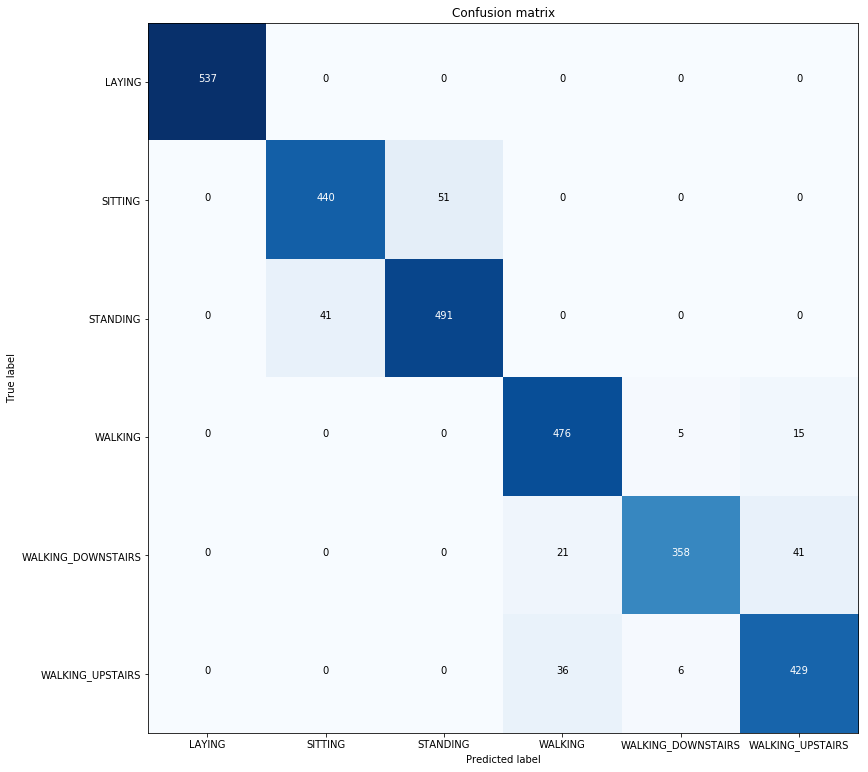

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12,12))
_ = plot_confusion_matrix(cm, classes=np.unique(y_test), ax=ax)

## Feature importance

Her er de 10 features som ble vektet høyest av vår modell:

In [29]:
importances = rf.feature_importances_
# Find index of those with highest importance, sorted from largest to smallest:
indices = np.argsort(importances)[::-1]
for f in range(10): 
    print(f'{X_test.columns[indices[f]]}: {np.round(importances[indices[f]],2)}')

tGravityAcc-mean()-X: 0.03
tGravityAcc-max()-X: 0.03
tGravityAcc-max()-Y: 0.03
tGravityAcc-min()-X: 0.03
angle(Y,gravityMean): 0.03
tGravityAcc-min()-Y: 0.03
tGravityAcc-energy()-X: 0.02
tGravityAcc-mean()-Y: 0.02
angle(X,gravityMean): 0.02
tGravityAcc-energy()-Y: 0.02


## Permutation importance

**Advarsel:** dette tar litt tid siden vi har såpass mange features-søyler som skal shuffles...

In [30]:
import eli5
from eli5.sklearn import PermutationImportance

In [31]:
#?PermutationImportance

In [32]:
perm = PermutationImportance(rf, random_state=42)

In [33]:
perm.fit(X_test, y_test)

PermutationImportance(cv='prefit',
           estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
           n_iter=5, random_state=42, refit=True, scoring=None)

In [34]:
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0045 ± 0.0018,"fBodyGyro-bandsEnergy()-1,16"
0.0037 ± 0.0019,fBodyAcc-max()-X
0.0035 ± 0.0011,"tGravityAcc-arCoeff()-Z,3"
0.0035 ± 0.0007,fBodyGyro-meanFreq()-X
0.0033 ± 0.0013,"tGravityAcc-arCoeff()-Z,2"
0.0031 ± 0.0007,tBodyGyro-iqr()-X
0.0031 ± 0.0019,tGravityAcc-min()-Z
0.0030 ± 0.0011,tBodyGyro-std()-X
0.0029 ± 0.0011,"tBodyAcc-correlation()-X,Y"
0.0027 ± 0.0009,tBodyGyro-max()-X


**Resultat:**

<img width=30% src="assets/permimportance_sensor.png">

# Fin-tuning

Som diskutert i notebooken fra Lab 1 er det en rekke ting en kan gjøre dersom en ikke er fornøyd med ytelsen til en maskinlæringsmodell. En av disse er å justere på såkalte **hyperparametre** i modellen (dvs parametre som ikke settes under trening, men velges av oss). 

Som vi skal se senere i laben (når vi kommer til hvordan random forests fungerer) er det en rekke hyperparametre i random forests som kan influere ytelsen. 

En mye brukt strategi for å finne gode valg av parametre er å *søke* gjennom et bestemt *grid* av potensielle parameterkombinasjoner. Enten ved å forsøke alle (dette kalles **grid search**) eller ved å forsøke et tilfeldig antall valg (dette kalles **randomized search**). Det finnes også andre, mer avanserte former for *hyperparameteroptimalisering*, for eksempel **bayesian search**. Vi skal se på grid search og randomized search. For bayesiansk søk, se for eksempel `scikit-optimize`: https://scikit-optimize.github.io/#skopt.BayesSearchCV.  

(Det er også mulig å søke gjennom ulike *modeller* i tillegg til deres hyperparemetre, men det skal vi ikke gå inn på her)

Vi forsøker:

## Et mulig parametergrid å søke gjennom

Her er to parametergrid som ofte vil fungere bra for random forest. Nøyaktig hvilke parametre som gir mening å forsøke i en gitt situasjon avhenger blant annet av datasettet en har. For å velge klokt her kreves det en del erfaring, samt forståelse av modellen. 

La oss bare velge noe relativt trygt, og så ikke bry oss om dette er det *beste* valget.

Vi lager to grids, et lite; et stort:

In [35]:
param_grid_small = {
    
    'max_depth': [5, 10, 15, 20, 30, 100, None],
    'n_estimators': [50, 100, 500, 1000]
    
}


param_grid_large = {
     'bootstrap': [True, False],
     'max_depth': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [50, 100, 500, 1000]
    }

Når vi senere kjører grid search, randomized search og bayesian search, blir disse grids konvertert til en type matriser, og alle kombinasjoner av parametre blir potensielle kandidater. 

Det betyr 7x4 = 28 kombinasjoner for `param_grid_small` og 2x12x3x3x4 = 864 kombinasjoner for `param_grid_large`.

## Grid search

Å søke gjennom absolutt alle kombinasjoner i `param_grid_large` blir for kostbart tidsmessig. Vi bruker derfor `param_grid_small`:

In [36]:
from sklearn.model_selection import GridSearchCV

In [37]:
rf_gs = GridSearchCV(estimator=rf, param_grid=param_grid_small, cv=3, n_jobs=-1)

In [38]:
rf_gs.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [5, 10, 15, 20, 30, 100, None], 'n_estimators': [50, 100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [39]:
best_gs_model = rf_gs.best_estimator_

In [40]:
best_gs_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [41]:
best_gs_model.score(X_test, y_test)

0.9222938581608415

Søket klarte i dette tilfellet ikke å finne en bedre parameterkombinasjon enn den vi allerede hadde. 

## Randomized search

Med randomized search er de vi som bestemmer antall (tilfeldig valgte) kombinasjoner som skal forsøkes. Vi kan derfor tillate oss å bruke `param_grid_large`:

In [42]:
from sklearn.model_selection import RandomizedSearchCV

In [43]:
rf_rs = RandomizedSearchCV(estimator=rf, param_distributions=param_grid_large, n_iter=50, cv=3, n_jobs=-1, random_state=42)

In [44]:
rf_rs.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=150, n_jobs=14,
          param_distributions={'bootstrap': [True, False], 'max_depth': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 5, 10], 'n_estimators': [50, 100, 500, 1000]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [45]:
best_rs_model = rf_rs.best_estimator_

In [46]:
best_rs_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [47]:
best_rs_model.score(X_test, y_test)

0.9277231082456736

Fortsatt ikke vesentlig bedre enn vår første modell. 

Med et større søk (det vil si, `n_iter` satt til et større tall) kan det hende at vi oppdager bedre parametre. Men jo større antall forsøk, jo lenger beregningstid...

> **Din tur!** Klarer du å lage en modell som kan predikere hvilken person som genererte hver sensormåling? <em>Gi meg din mobiltelefon så skal jeg fortelle deg hvem du er</em>

> Undersøk hvilke bevegelser som best skiller personer fra hverandre.

# Ekstra

La oss forsøke en annen modell: **logistisk regresjon**:

In [48]:
from sklearn.linear_model import LogisticRegression

In [49]:
log_reg = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=500, C=0.3, random_state=42)
log_reg.fit(X_train, y_train)

/home/alex/anaconda3/envs/elmed219/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=0.3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [50]:
log_reg.score(X_test, y_test)

0.9602986087546658

Denne modellen scorer 96%, altså langt bedre enn de random forest-variantene vi forsøkte over. Dette illusterer viktigheten av hensiktsmessig modellvalg, tilpasset data og problemstilling man står ovenfor.

## Forvirringsmatrise

In [51]:
y_pred_logreg = log_reg.predict(X_test)

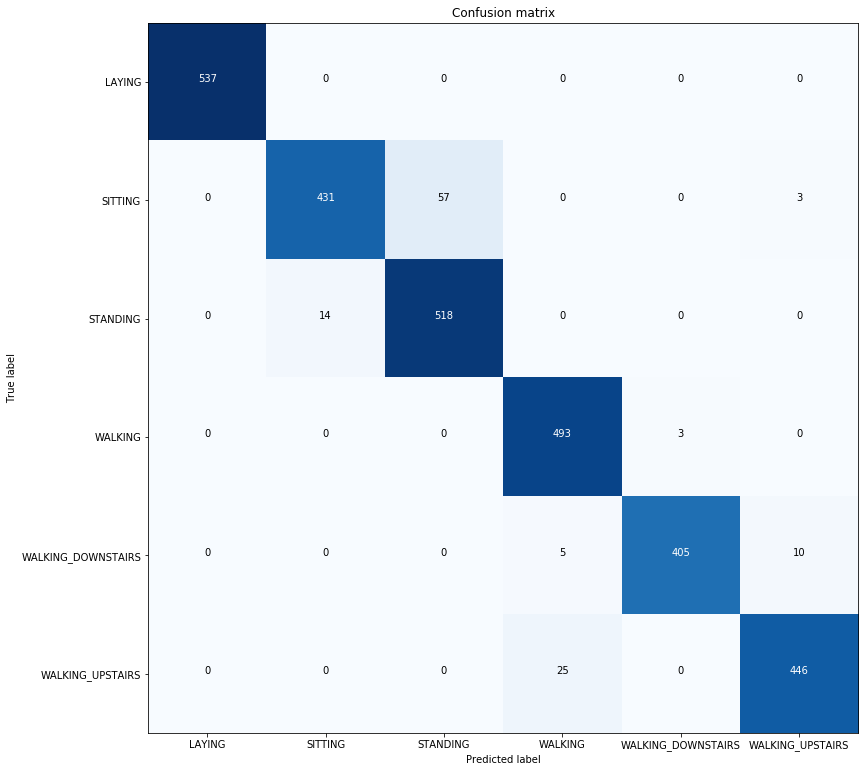

In [52]:
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
fig, ax = plt.subplots(figsize=(12,12))
_ = plot_confusion_matrix(cm_logreg, classes=np.unique(y_test), ax=ax)

Denne kan sammenlignes fra vår forvirringsmatrise fra random forest:

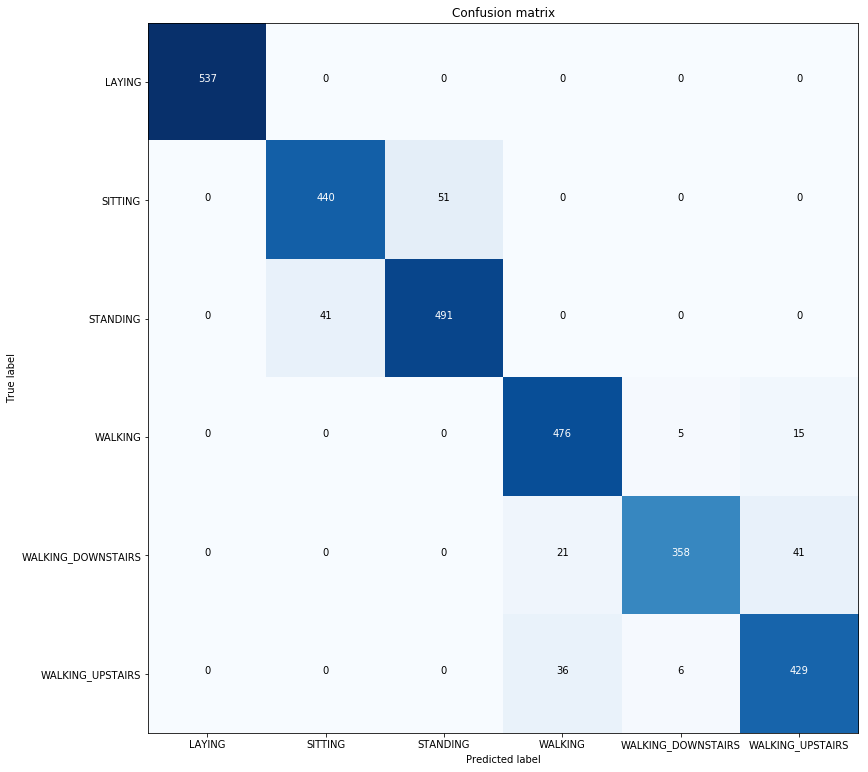

In [53]:
fig, ax = plt.subplots(figsize=(12,12))
_ = plot_confusion_matrix(cm, classes=np.unique(y_test), ax=ax)

# Ekstra ekstra

For moro skyld, la oss også forsøke noe kraftigere: en gradient boosting-basert modell.

In [54]:
from sklearn.ensemble import GradientBoostingClassifier

In [55]:
gb = GradientBoostingClassifier(random_state=42, n_estimators=500)

In [56]:
gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [57]:
gb.score(X_test, y_test)

0.9389209365456397

Ca. 94%.

## Forvirringsmatrise

In [58]:
y_pred_gs = gb.predict(X_test)

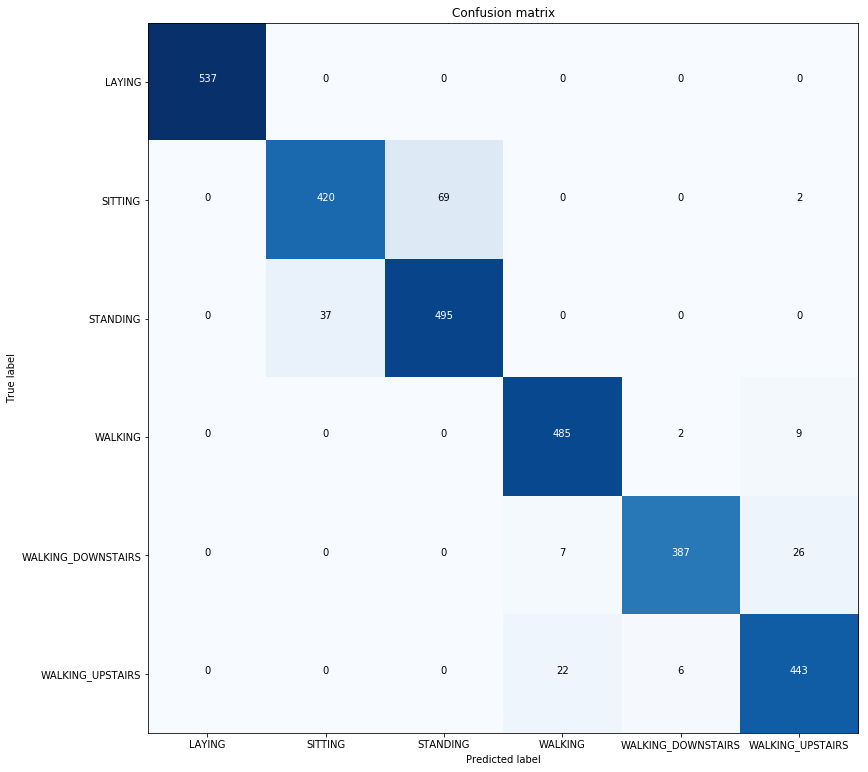

In [59]:
cm_gs = confusion_matrix(y_test, y_pred_gs)
fig, ax = plt.subplots(figsize=(12,12))
_ = plot_confusion_matrix(cm_gs, classes=np.unique(y_test), ax=ax)

En (av mange) mulige måter å forbedre modeller på er å bruke **ensembling**: slå sammen prediksjonene fra flere modeller. Dette er spesielt nyttig dersom man har flere, svært ulike modeller, som hver for seg scorer høyt. Sammen kan de da ofte bli enda bedre (*wisdom of the crowd*).

La oss forsøke med de vi har til nå:

In [60]:
from sklearn.ensemble import VotingClassifier

In [61]:
eclf = VotingClassifier(estimators=[('rf', best_rs_model), ('logreg', log_reg), ('gnb', gb)], voting='soft')

In [62]:
eclf.fit(X_train, y_train)

/home/alex/anaconda3/envs/elmed219/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=5,
            min_weig...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [63]:
eclf.score(X_test, y_test)

0.9497794367153037

I vårt tilfelle gav ikke dette en bedre modell enn logistisk regresjon alene.

In [64]:
y_pred_eclf = eclf.predict(X_test)

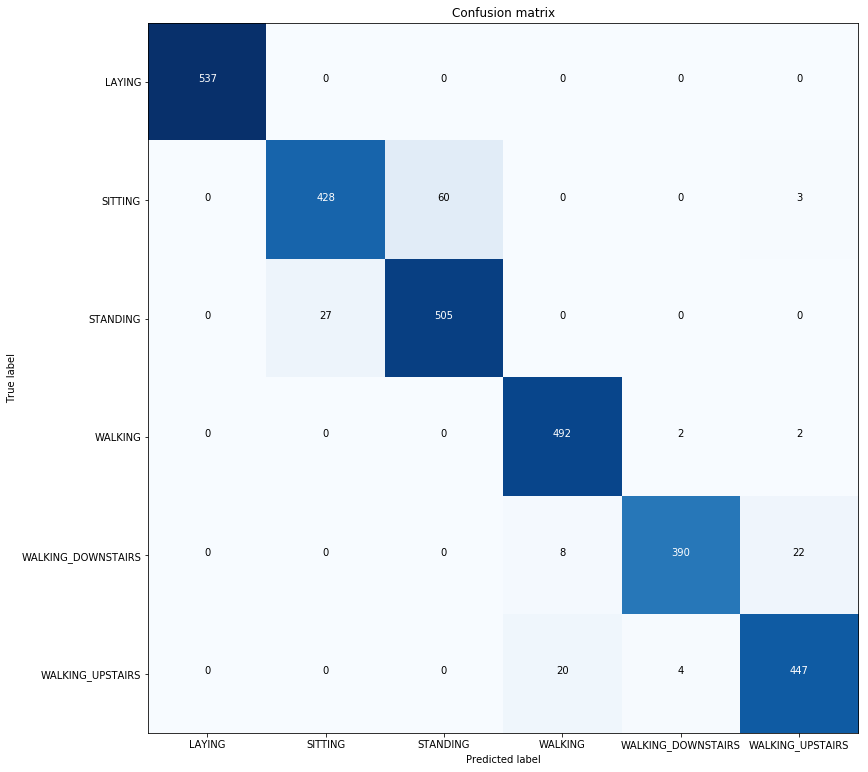

In [65]:
cm_eclf = confusion_matrix(y_test, y_pred_eclf)
fig, ax = plt.subplots(figsize=(12,12))
_ = plot_confusion_matrix(cm_eclf, classes=np.unique(y_test), ax=ax)

In [66]:
# Merk: For å slippe å trene modellene på nytt når de ensembles kunne vi brukt mlextend sin EnsembleVoteClassifier. Det vil spare mye tid:
#from mlxtend.classifier import EnsembleVoteClassifier
#import copy
#eclf = EnsembleVoteClassifier(clfs=[best_rs_model, gnb], weights=[1,1], refit=False)